# delegation.ipynb

This notebook is used to test the implementatin of 'delegation' synapses in draculab.

Delegation synapses: 
* `diff_hebb_subsnorm_synapse`

By: Sergio Verduzco Flores                                
August-September 2017

In [1]:
from draculab import *
from matplotlib import pyplot as plt
import numpy as np
import time

In this simulation you have a unit receiving several inputs. Among them, one is an increasing function of the unit's activity. This means $I(t) = f(u(t-\Delta))$, and $x_2 > x_1 \Rightarrow f(x_2) \geq f(x_1)$, where $I$ is the input, $u$ is the unit's activity, and $\Delta$ is the delay of the input. The other inputs will be random processes independent of $u$.

The rule will work if the synapse for $I$ becomes the one with the largest weight.

In [2]:
class delegation1():
    def __init__(self):
        """ Sets all the default parameters. """
        self.n_inp = 3 # number of additional inputs
        # Network parameters
        self.md = 0.1 # minimum delay in the network
        self.min_buff_size = 3 # minimum buffer size
        self.rtol = 1e-4 # relative tolerance of the ODE solver
        self.atol = 1e-4 # absolute tolerance of the ODE solver
        # source unit parameters
        self.inp_init_val = 0.2
        self.inp_tau_fast = 0.2
        self.inp_tau_mid = 3.
        # delegate unit parameters
        self.u_type = unit_types.sigmoidal
        self.u_init_val = 0.5
        self.u_tau = 2.
        self.u_slope = 2.5
        self.u_thresh = 0.2
        self.u_tau_fast = 0.2
        self.u_tau_mid = 3.
        # connection parameters
        self.conn_delay = 0.2
        self.syn_type = synapse_types.diff_hebbsnorm
        self.init_w = {'distribution':'uniform', 'low':0.3, 'high':0.5}
        self.lrate = 1./20.
        
    def build(self):
        """ Run this before first run(), or if you change the paramaters. """
        # creating network
        net_params = {'min_delay' : self.md, 
                      'min_buff_size' : self.min_buff_size, 
                      'rtol':self.rtol, 
                      'atol':self.atol }
        self.net = network(net_params)
        # creating input units
        inp_params = {'type' : unit_types.source, 
                      'init_val' : self.inp_init_val, 
                      'function' : lambda x: None,
                      'tau_fast' : self.inp_tau_fast,
                      'tau_mid' : self.inp_tau_mid }
        self.inp = self.net.create_units(self.n_inp, inp_params)
        self.I = self.net.create_units(1, inp_params) # the input that increases with u
        self.inp_ws = self.net.create_units(len(self.inp), inp_params) # to track the weights
        self.I_w = self.net.create_units(1, inp_params) # to track the main weight
        self.I_d = self.net.create_units(1, inp_params) # to track the input's derivative
        self.u_d = self.net.create_units(1, inp_params) # to track the derivative of the delegate unit
        self.avg_d = self.net.create_units(1, inp_params) # to track the average derivative
        # creating delegate unit
        u_params = {'type' : self.u_type,
                    'init_val' : self.u_init_val, 
                    'tau' : self.u_tau,
                    'slope' : self.u_slope,
                    'thresh' : self.u_thresh,
                    'tau_fast' : self.u_tau_fast,
                    'tau_mid' : self.u_tau_mid }
        self.u = self.net.create_units(1, u_params)
        # setting the input functions uncorrelated with the unit's activity
        n_comp = np.random.randint(4, 10, self.n_inp) # number of sin,cos components for each input
        freqs = [range(0, c) + np.random.normal(0., 0.5, c) for c in n_comp] # frequency of each component
        sin_amps = [np.random.normal(0.2, .1, c) for c in n_comp] # amplitudes for sin components
        cos_amps = [np.random.normal(0.2, .1, c) for c in n_comp] # amplitudes for cos components
        def make_fun(i):
            return lambda t: sum(sin_amps[i]*np.sin(freqs[i]*t) + cos_amps[i]*np.cos(freqs[i]*t))
        functions = [make_fun(i) for i in range(self.n_inp)]
        for idx, uni in enumerate(self.inp):
            self.net.units[uni].set_function(functions[idx])
        # setting the transformation I = f(u)
        self.net.units[self.I[0]].set_function(lambda t: 1.*self.net.units[self.u[0]].get_act(t-self.net.min_delay))
        # connecting
        conn_spec = {'rule' : 'all_to_all',
                     'delay' : self.conn_delay }
        syn_spec = {'type' : self.syn_type,
                    'init_w' : self.init_w,
                    'lrate' : self.lrate }
        self.net.connect(self.inp+self.I, self.u, conn_spec, syn_spec)
        # tracking the weights with the 'weights' units
        #for idx, uni in enumerate(self.inp_ws):
        #    self.net.units[uni].set_function(self.net.syns[self.u[0]]:
        for syn in self.net.syns[self.u[0]]:
            if syn.preID in self.inp:
                self.net.units[self.inp_ws[syn.preID-self.inp[0]]].set_function(syn.get_w)
            elif syn.preID == self.I[0]:
                self.net.units[self.I_w[0]].set_function(syn.get_w)
        # tracking the derivatives with the "_d" units
        for syn in self.net.syns[self.u[0]]:
            if syn.preID == self.I[0]:
                self.Idels = syn.delay_steps
                dfun1 = lambda t: (self.net.units[self.I[0]].get_lpf_fast(self.Idels) - 
                                  self.net.units[self.I[0]].get_lpf_mid(self.Idels) )
                self.net.units[self.I_d[0]].set_function(dfun1)
        dfun2 = lambda t: self.net.units[self.u[0]].lpf_fast - self.net.units[self.u[0]].lpf_mid
        self.net.units[self.u_d[0]].set_function(dfun2)
        self.net.units[self.avg_d[0]].set_function(lambda t: self.net.units[self.u[0]].diff_avg)
                                             
    def plot_inputs(self, t_min, t_max):
        t_vals = np.linspace(t_min, t_max, 300)
        f_vals = np.transpose([np.array([self.net.units[i].get_act(t) for t in t_vals]) for i in range(self.n_inp)])
        fig = plt.figure(figsize=(12,8))
        plt.plot(t_vals, f_vals, linewidth=1)
        plt.show()
        
    
        
    def w_sums(self):
        """ Print the sum of synaptic weights for the delegate unit. """
        s = sum([syn.w for syn in self.net.syns[self.u[0]]])
        print( "Sum of weights in delegate unit: " + str(s) )
        
    def run(self, t_sim):
        start_time = time.time()
        self.times, self.units, plants = self.net.run(t_sim)  # simulating
        print('Execution time is %s seconds' % (time.time() - start_time)) 

In [3]:
dely = delegation1()
dely.n_inp = 20
dely.build()
sim_time = 300.
#dely.plot_inputs(0.,sim_time)
dely.w_sums()
dely.run(sim_time)
dely.w_sums()

Sum of weights in delegate unit: 8.2773402475
Execution time is 7.3453803062438965 seconds
Sum of weights in delegate unit: 8.2773402475


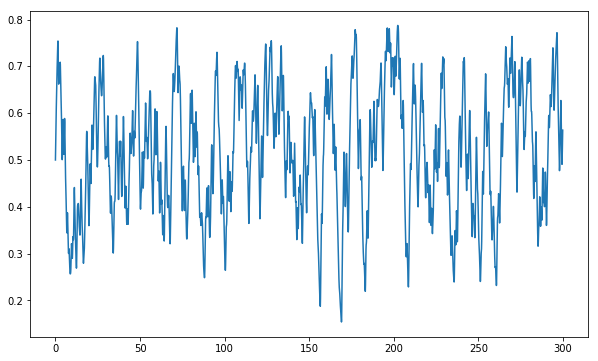

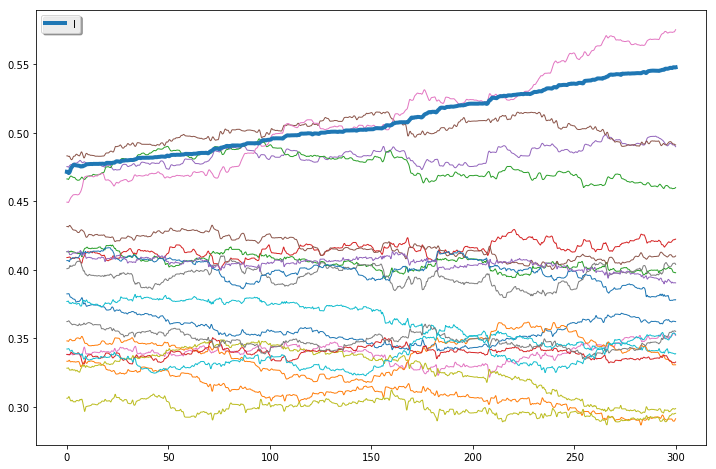

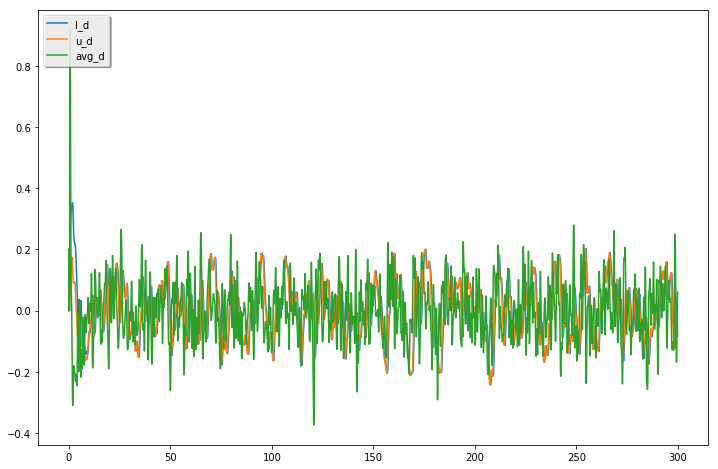

In [4]:
# Plot the unit's activity
act_fig = plt.figure(figsize=(10,6))
plt.plot(dely.times, dely.units[dely.u[0]])

# Plot the evolution of the synaptic weights
w_fig = plt.figure(figsize=(12,8))
weights = np.transpose([dely.units[dely.inp_ws[i]] for i in range(dely.n_inp)])
plt.plot(dely.times, weights, linewidth=1)
plt.plot(dely.times, dely.units[dely.I_w[0]], label="I", linewidth=4)
plt.legend(loc="upper left", bbox_to_anchor=[0, 1], ncol=1, shadow=True)

# Plot the derivatives of the u activity, the I input, and the average input
d_fig = plt.figure(figsize=(12,8))
plt.plot(dely.times, dely.units[dely.I_d[0]], label="I_d")
plt.plot(dely.times, dely.units[dely.u_d[0]], label="u_d")
plt.plot(dely.times, dely.units[dely.avg_d[0]], label="avg_d")
plt.legend(loc="upper left", bbox_to_anchor=[0, 1], ncol=1, shadow=True)
plt.show()

---

---
In this simulation you have a pendulum with almost no friction, being moved by gravity, random torque inputs, and positive/negative torques that comes from the output of 2 units. Among the inputs of the unit are sigmoidal functions of the pendulum's angle (modulo $2\pi$) and its angular velocity. Other inputs are either random and uncorrelated to the pendulum's state, or nonmonotonic functions of a state variable.

As before, the learning rule must select the inputs from angle and angular velocity in the unit that provides positive torque.

In [5]:
class delegation2():
    def __init__(self):
        """Sets up all default parameters.
        
            Time constants are now expressed in seconds. 
        """
        # Network parameters
        self.md = 0.005 # minimum delay in the network. 5 ms.
        self.min_buff_size = 3 # minimum buffer size
        self.rtol = 1e-4 # relative tolerance of the ODE solver
        self.atol = 1e-4 # absolute tolerance of the ODE solver
        # Plant parameters
        self.pend_type = plant_models.pendulum
        self.pend_length = 2. # length in meters
        self.pend_mass = 2. # mass in kg
        self.pend_mu = 0.01 # viscous friction coefficient
        self.pend_init_angle = 0. # initial angle in radians. 0 rads is X axis.
        self.pend_init_vel = 0. # initial ang vel in rad/s.
        self.pend_g = 3. # gravitational acceleration in m/s^2. Points opposite to Y axis.
        self.pend_inp_gain = 1. # input gain
        # parameters for source unit inputs to plant and delegate unit  
        self.i2u_n_inp = 2 # number of inputs to the delegate unit
        self.i2p_n_inp = 2 # number of inputs to the plant
        self.inp_init_val = 0.2
        self.inp_tau_fast = 0.01
        self.inp_tau_mid = .15
        self.i2u_scale = 0.5 # factor that scales the i2u inputs
        self.ncomp_low = 5 # minimum number of sine and cosine components for each input
        self.ncomp_high = 10 # maximum number of sine and cosine components for each input
        self.comp_am = 0.1 # mean component amplitude
        self.comp_as = 0.1 # standard deviation of component amplitudes
        self.comp_fm = 0. # mean component frequency bias
        self.comp_fs = 0.5 # standard deviation of component frequencies
        # delegate unit parameters
        self.u_type = unit_types.sigmoidal
        self.u_init_val = 0.5
        self.u_tau = .1
        self.u_slope = 2.5
        self.u_thresh = 0.2
        self.u_tau_fast = 0.01
        self.u_tau_mid = .15
        # afferent unit parameters
        self.aff_type = unit_types.sigmoidal
        self.aff_init_val = 0.5
        self.aff_tau = .05
        self.aff_slope = 2.
        self.aff_thresh = 0.
        self.aff_tau_fast = 0.01
        self.aff_tau_mid = .15
        # connections from input to delegate unit parameters
        self.i2u_conn_delay = 0.01
        self.i2u_syn_type = synapse_types.diff_hebbsnorm
        self.i2u_init_w = {'distribution':'uniform', 'low':0.3, 'high':0.5}
        self.i2u_lrate = 1./2.
        # connections from  inputs to pendulum
        self.i2p_conn_delays = 0.02
        self.i2p_syn_type = synapse_types.static
        self.i2p_init_w = {'distribution':'uniform', 'low':0.3, 'high':0.5}
        # connection from delegate units to pendulum
        self.u2p_delays = 0.02
        self.u2p_syn_type = synapse_types.static
        self.u2p_init_w = [.5, -.5] # counterclockwise (positive) and clockwise (negative)
        # connections from pendulum to afferent units
        self.p2aff_port_map = [[(0,0)], [(1,0)]]
        self.p2aff_delays = 0.02
        self.p2aff_syn_type = synapse_types.static
        self.p2aff_init_w = 1.
        # connections from afferent units to delegate unit
        self.aff2u_conn_delay = 0.01
        self.aff2u_syn_type = synapse_types.diff_hebbsnorm
        self.aff2u_init_w = 0.4
        self.aff2u_lrate = 1./2.
        
    def build(self):
        """ Run this before first run(), or if you change the paramaters. """
        # CREATING NETWORK, UNITS, AND PLANT
        # creating network
        net_params = {'min_delay' : self.md, 
                      'min_buff_size' : self.min_buff_size, 
                      'rtol':self.rtol, 
                      'atol':self.atol }
        self.net = network(net_params)
        # creating the plant
        plant_params = {'type' : self.pend_type, 
                        'length' : self.pend_length, 
                        'g' : self.pend_g,
                        'inp_gain' : self.pend_inp_gain,
                        'mass' : self.pend_mass, 
                        'mu' : self.pend_mu, 
                        'init_angle' : self.pend_init_angle, 
                        'init_ang_vel' : self.pend_init_vel }
        self.pend = self.net.create(1, plant_params)
        # creating delegate units
        u_params = {'type' : self.u_type,
                    'init_val' : self.u_init_val, 
                    'tau' : self.u_tau,
                    'slope' : self.u_slope,
                    'thresh' : self.u_thresh,
                    'tau_fast' : self.u_tau_fast,
                    'tau_mid' : self.u_tau_mid }
        self.u = self.net.create_units(2, u_params)
        # creating input units
        inp_params = {'type' : unit_types.source, 
                      'init_val' : self.inp_init_val, 
                      'function' : lambda x: None,
                      'tau_fast' : self.inp_tau_fast,
                      'tau_mid' : self.inp_tau_mid }
        self.inp2u = self.net.create_units(self.i2u_n_inp, inp_params) # inputs to delegate units
        self.inp2p = self.net.create_units(self.i2p_n_inp, inp_params) # inputs to plant
        # creating units that track the plant's state variables (afferent units)
        aff_params = {'type' : self.aff_type,
                      'init_val' : self.aff_init_val, 
                      'tau' : self.aff_tau,
                      'slope' : self.aff_slope,
                      'thresh' : self.aff_thresh,
                      'tau_fast' : self.aff_tau_fast,
                      'tau_mid' : self.aff_tau_mid }
        self.aff = self.net.create_units(2, aff_params) # aff[0] gets angle, aff[1] gets velocity
        # creating units that track the synaptic weights for the delegate unit
        track_params = {'type' : unit_types.source,
                         'init_val' : self.inp_init_val,
                         'function' : lambda x: None }
        self.inp_cc_w = self.net.create(self.i2u_n_inp, track_params) #  input weights to counterclockwise unit
        self.aff_cc_w = self.net.create(2, track_params) # to track the afferent inputs
        self.inp_cw_w = self.net.create(self.i2u_n_inp, track_params) # input weights to clockwise unit
        self.aff_cw_w = self.net.create(2, track_params) # to track the afferent inputs
        # creating units that track derivatives of delegate unit and its inputs
        self.avg_d = self.net.create(1, track_params)  # average input derivative
        self.aff0_d = self.net.create(1, track_params)  # angle aff derivative
        self.aff1_d = self.net.create(1, track_params)  # vel aff derivative
        self.u_d = self.net.create(2, track_params)   # delegate units derivatives
        
        # CONNECTING
        ## connectig afferent units to delegate units 
        aff2u_conn = {'rule' : 'all_to_all',
                      'delay' : self.aff2u_conn_delay }
        aff2u_syn = {'type' : self.aff2u_syn_type,
                     'init_w' : self.aff2u_init_w,
                     'lrate' : self.aff2u_lrate }
        self.net.connect(self.aff, self.u, aff2u_conn, aff2u_syn)
        ## connecting inputs to the delegate units
        i2u_conn = {'rule' : 'all_to_all',
                    'delay' : self.i2u_conn_delay }
        i2u_syn = {'type' : self.i2u_syn_type, 
                   'init_w' : self.i2u_init_w,
                   'lrate' : self.i2u_lrate }
        self.net.connect(self.inp2u, self.u,  i2u_conn, i2u_syn)
        ## connecting inputs to the pendulum
        i2p_conn = {'inp_ports' : [0]*len(self.inp2p),
                    'delays' : self.i2p_conn_delays }
        i2p_syn = {'type' : self.i2p_syn_type, 
                   'init_w' : self.i2p_init_w }
        self.net.set_plant_inputs(self.inp2p, self.pend,  i2p_conn, i2p_syn)
        ## connecting delegate units to the pendulum
        u2p_conn = {'inp_ports' : [0, 0],
                    'delays' : self.u2p_delays }
        u2p_syn = {'type' : self.u2p_syn_type,
                   'init_w' : self.u2p_init_w }
        self.net.set_plant_inputs(self.u, self.pend, u2p_conn, u2p_syn)
        ## connecting pendulum to afferent units
        p2aff_conn = {'port_map' : self.p2aff_port_map,
                      'delays' : self.p2aff_delays }
        p2aff_syn = {'type' : self.p2aff_syn_type,
                     'init_w' : self.p2aff_init_w }
        self.net.set_plant_outputs(self.pend, self.aff, p2aff_conn, p2aff_syn)
        
        # SETTING THE INPUT FUNCTIONS FOR SOURCE UNITS 
        ## For each input you select a random number of sine and cosine components, 
        ## and to each component you assign random frequencies, and random amplitudes
        def make_inp_fun(f, a_sin, a_cos):
            # given numpy arrays with frequencies and amplitudes, return the input function
            return lambda t: self.i2u_scale*sum(a_sin*np.sin(f*t) + a_cos*np.cos(f*t))
        for inp in (self.inp2u + self.inp2p): # setting inputs to delegate unit and plant
            n_comp = np.random.randint(self.ncomp_low, self.ncomp_high) # number of components
            freqs = np.array(range(0,n_comp) + np.random.normal(self.comp_am, self.comp_as, n_comp))
            sin_amps = np.random.normal(self.comp_fm, self.comp_fs, n_comp) # sine amplitudes
            cos_amps = np.random.normal(self.comp_fm, self.comp_fs, n_comp) # cosine amplitudes
            self.net.units[inp].set_function(make_inp_fun(freqs, sin_amps, cos_amps))
        ## Setting functions that track weights
        for syn in self.net.syns[self.u[0]]:  # weights to counterclockwise unit
            if syn.preID in self.inp2u:  # synapse is from uncorrelated input
                self.net.units[self.inp_cc_w[syn.preID-self.inp2u[0]]].set_function(syn.get_w)
            elif syn.preID in self.aff:  # synapse is from afferent unit
                self.net.units[self.aff_cc_w[syn.preID-self.aff[0]]].set_function(syn.get_w)
        for syn in self.net.syns[self.u[1]]: # weights to clockwise unit
            if syn.preID in self.inp2u:  # synapse is from uncorrelated input
                self.net.units[self.inp_cw_w[syn.preID-self.inp2u[0]]].set_function(syn.get_w)
            elif syn.preID in self.aff:  # synapse is from afferent unit
                self.net.units[self.aff_cw_w[syn.preID-self.aff[0]]].set_function(syn.get_w)
        ## tracking the derivatives with the "_d" units
        for syn in self.net.syns[self.u[0]]:
            if syn.preID == self.aff[0]:
                self.aff0dels = syn.delay_steps
                dfun0 = lambda t: (self.net.units[self.aff[0]].get_lpf_fast(self.aff0dels) - 
                                   self.net.units[self.aff[0]].get_lpf_mid(self.aff0dels) )
                self.net.units[self.aff0_d[0]].set_function(dfun0)
            if syn.preID == self.aff[1]:
                self.aff1dels = syn.delay_steps
                dfun1 = lambda t: (self.net.units[self.aff[1]].get_lpf_fast(self.aff1dels) - 
                                   self.net.units[self.aff[1]].get_lpf_mid(self.aff1dels) )
                self.net.units[self.aff1_d[0]].set_function(dfun1)
        dfun2cc = lambda t: self.net.units[self.u[0]].lpf_fast - self.net.units[self.u[0]].lpf_mid
        dfun2cw = lambda t: self.net.units[self.u[1]].lpf_fast - self.net.units[self.u[1]].lpf_mid
        self.net.units[self.u_d[0]].set_function(dfun2cc)
        self.net.units[self.u_d[1]].set_function(dfun2cw)
        self.net.units[self.avg_d[0]].set_function(lambda t: self.net.units[self.u[0]].diff_avg)
        
    def plot_inputs(self, t_min, t_max):
        t_vals = np.linspace(t_min, t_max, 300)
        f_vals = np.transpose([np.array([self.net.units[i].get_act(t) for t in t_vals]) for i in self.inp2u])
        fig = plt.figure(figsize=(16,8))
        plt.plot(t_vals, f_vals, linewidth=2)
        plt.plot(t_vals, np.zeros(len(t_vals)), 'k--', linewidth=1)
        plt.title('Uncorrelated inputs')
        plt.show()
        
    def run(self, t_sim):
        start_time = time.time()
        self.times, self.units, self.plants = self.net.run(t_sim)  # simulating
        print('Execution time is %s seconds' % (time.time() - start_time)) 
        
    def w_sums(self):
        """ Print the sum of synaptic weights for the delegate unit. """
        scc = sum([syn.w for syn in self.net.syns[self.u[0]]])
        scw = sum([syn.w for syn in self.net.syns[self.u[1]]])
        print( "CC sum: " + str(scc) + ", CW sum: " + str(scw) )

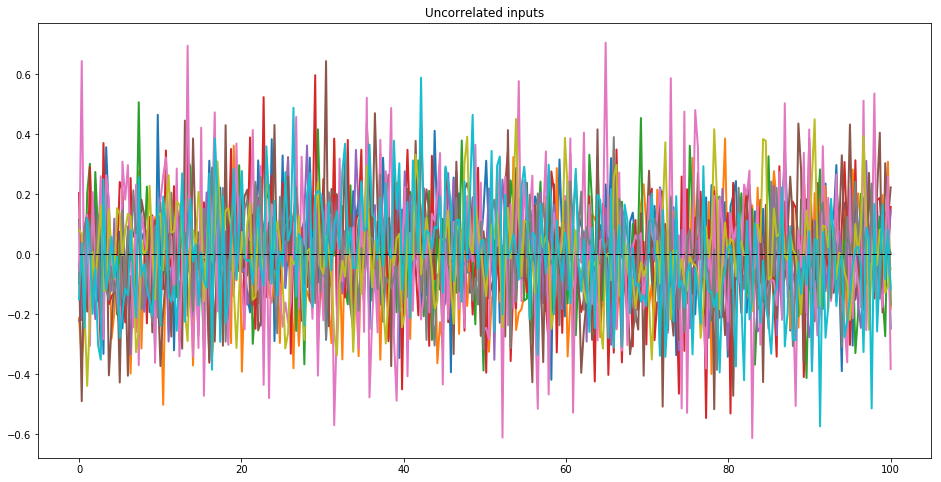

CC sum: 4.52138093095, CW sum: 4.80820308882
Execution time is 81.79377627372742 seconds
         49994737 function calls (49254737 primitive calls) in 81.794 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
  3802306   19.178    0.000   26.613    0.000 <ipython-input-5-0cdb57bfb7d1>:172(<lambda>)
    20000    0.034    0.000    0.054    0.000 <ipython-input-5-0cdb57bfb7d1>:194(<lambda>)
    20000    0.025    0.000    0.035    0.000 <ipython-input-5-0cdb57bfb7d1>:199(<lambda>)
    20000    0.014    0.000    0.014    0.000 <ipython-input-5-0cdb57bfb7d1>:202(<lambda>)
    20000    0.013    0.000    0.013    0.000 <ipython-input-5-0cdb57bfb7d1>:203(<lambda>)
    20000    0.014    0.000    0.014    0.000 <ipython-input-5-0cdb57bfb7d1>:206(<lambda>)
        1    0.000    0.000   81.794   81.794 <ipython-input-5-0cdb57bfb7d1>:217(run)
        1    0.000    0.000   81.794   81.794 <string>:1(<module>)
   300034    1.509    0.000    

In [6]:
""" Using the delegation2 class to run a simulation. """
delz = delegation2()

# parameter changes
delz.ncomp_high = 20
delz.i2u_n_inp = 10
delz.i2u_scale = 0.1
delz.pend_inp_gain = 5
delz.pend_g = .5
delz.pend_mass = 1.
delz.pend_mu = 0.05
delz.aff_thresh = -.8
delz.aff2u_lrate = -1./2.

# build
delz.build()

# simulation
sim_time = 100.
delz.plot_inputs(0.,sim_time)
delz.w_sums()
import cProfile
cProfile.run('delz.run(sim_time)')
#delz.run(sim_time)
delz.w_sums()

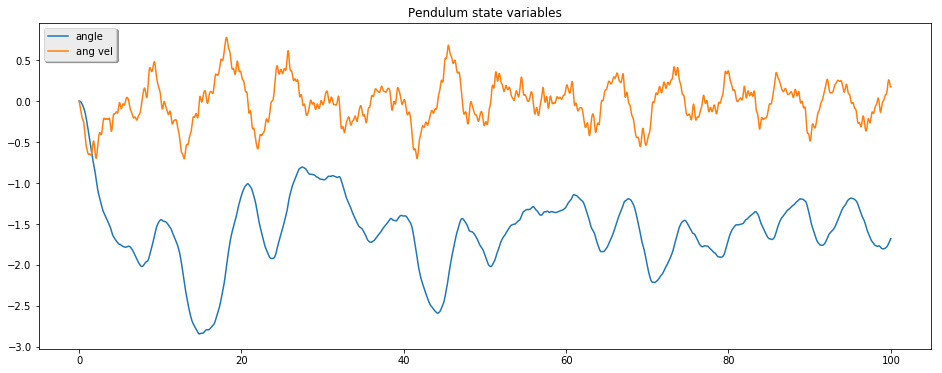

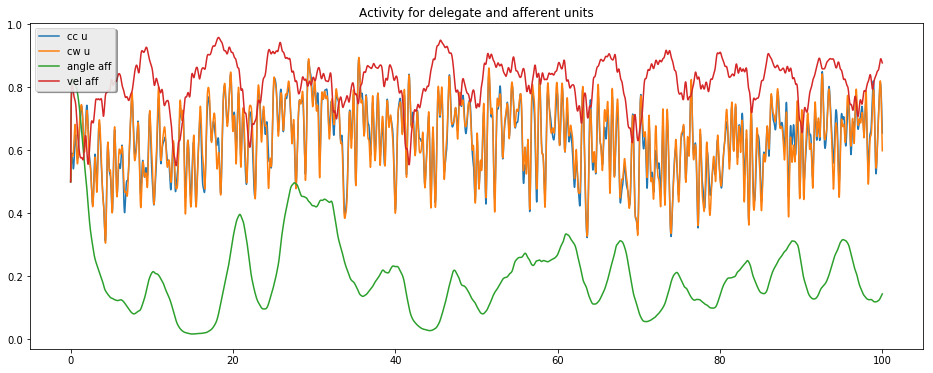

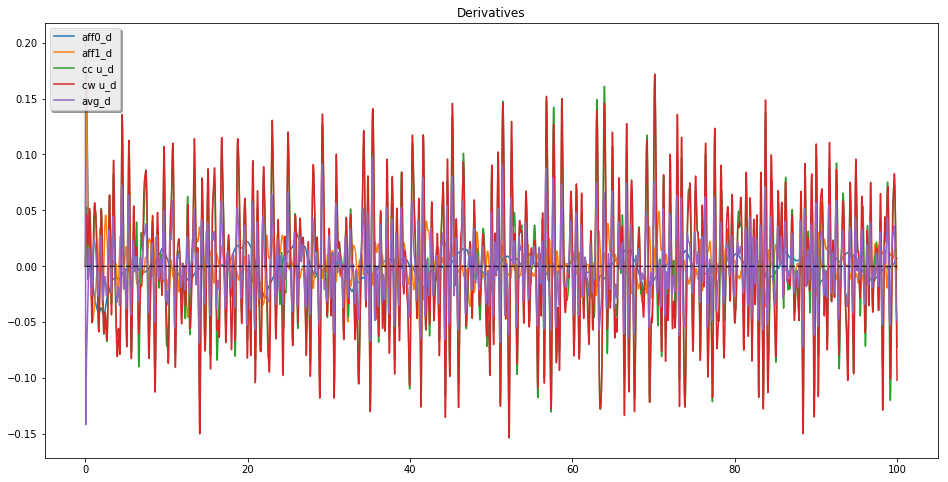

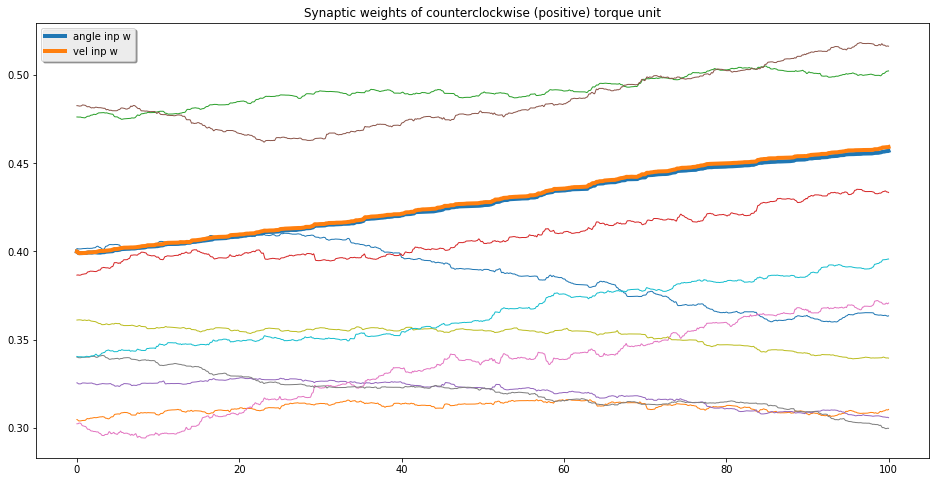

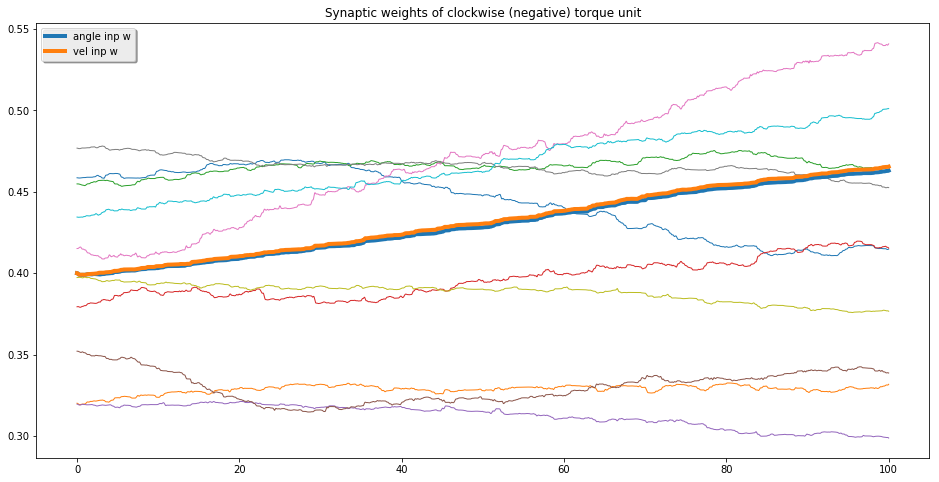

In [7]:
# Plot the pendulum's state variables
pend_fig = plt.figure(figsize=(16,6))
plt.plot(delz.times, delz.plants[0][:,0], label="angle")
plt.plot(delz.times, delz.plants[0][:,1], label="ang vel")
plt.legend(loc="upper left", bbox_to_anchor=[0, 1], ncol=1, shadow=True)
plt.title('Pendulum state variables')

# Plot the units activities
act_fig = plt.figure(figsize=(16,6))
plt.plot(delz.times, delz.units[delz.u[0]], label="cc u")
plt.plot(delz.times, delz.units[delz.u[1]], label="cw u")
plt.plot(delz.times, delz.units[delz.aff[0]], label="angle aff")
plt.plot(delz.times, delz.units[delz.aff[1]], label="vel aff")
plt.legend(loc="upper left", bbox_to_anchor=[0, 1], ncol=1, shadow=True)
plt.title('Activity for delegate and afferent units')

# Plot the derivatives of the u activities, the afferent inputs, and the average input
d_fig = plt.figure(figsize=(16,8))
plt.plot(delz.times, delz.units[delz.aff0_d[0]], label="aff0_d")
plt.plot(delz.times, delz.units[delz.aff1_d[0]], label="aff1_d")
plt.plot(delz.times, delz.units[delz.u_d[0]], label="cc u_d")
plt.plot(delz.times, delz.units[delz.u_d[1]], label="cw u_d")
plt.plot(delz.times, delz.units[delz.avg_d[0]], label="avg_d")
plt.plot(delz.times, np.zeros(len(delz.times)), 'k--', linewidth=1)
plt.legend(loc="upper left", bbox_to_anchor=[0, 1], ncol=1, shadow=True)
plt.title('Derivatives')

# Plot the evolution of the synaptic weights
w_cc_fig = plt.figure(figsize=(16,8))
weights = np.transpose([delz.units[delz.inp_cc_w[i]] for i in range(delz.i2u_n_inp)])
plt.plot(delz.times, weights, linewidth=1)
plt.plot(delz.times, delz.units[delz.aff_cc_w[0]], label="angle inp w", linewidth=4)
plt.plot(delz.times, delz.units[delz.aff_cc_w[1]], label="vel inp w", linewidth=4)
plt.legend(loc="upper left", bbox_to_anchor=[0, 1], ncol=1, shadow=True)
plt.title('Synaptic weights of counterclockwise (positive) torque unit')
w_cw_fig = plt.figure(figsize=(16,8))
weights = np.transpose([delz.units[delz.inp_cw_w[i]] for i in range(delz.i2u_n_inp)])
plt.plot(delz.times, weights, linewidth=1)
plt.plot(delz.times, delz.units[delz.aff_cw_w[0]], label="angle inp w", linewidth=4)
plt.plot(delz.times, delz.units[delz.aff_cw_w[1]], label="vel inp w", linewidth=4)
plt.legend(loc="upper left", bbox_to_anchor=[0, 1], ncol=1, shadow=True)
plt.title('Synaptic weights of clockwise (negative) torque unit')

plt.show()